# Check QKernel Transpilation

When we submit a qkernel instance we can leave the transpilation to the optimization process in the sampler or we can submit a pretranspiled ftmap. However since the kernel is the composition of the featuremap and its transpose we would like to check if the final circuit, to run on the Quantum device, is further transpiled when we use a already transpiled ft map.
To check this we compare the following circuits:

* $ftmap_{transposed} +(ftmap_{transposed})^T$
* Qkernel as its handled by the FidelityQuantumKernel instance when we submit a transpiled ft map.

In [1]:
#import qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
# Importing standard Qiskit libraries and configuring account
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Batch
import qiskit_ibm_runtime 
#Load feature maps
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.providers.fake_provider import FakeCairoV2
from qiskit_machine_learning.kernels import FidelityQuantumKernel


In [3]:
service=QiskitRuntimeService(channel="ibm_quantum",
                             token="95e70510a429e03c7cc4ce4c5c979c794135dbacffbebe5325dcd8b627cfe42c9f61e91945ba1adea992f81849c74cc5e0ed1ab93977db5084dd26a28fd25dd8")
#Get example backend
backend = service.get_backend("ibm_cairo")
target = backend.target
coupling_map = target.build_coupling_map()


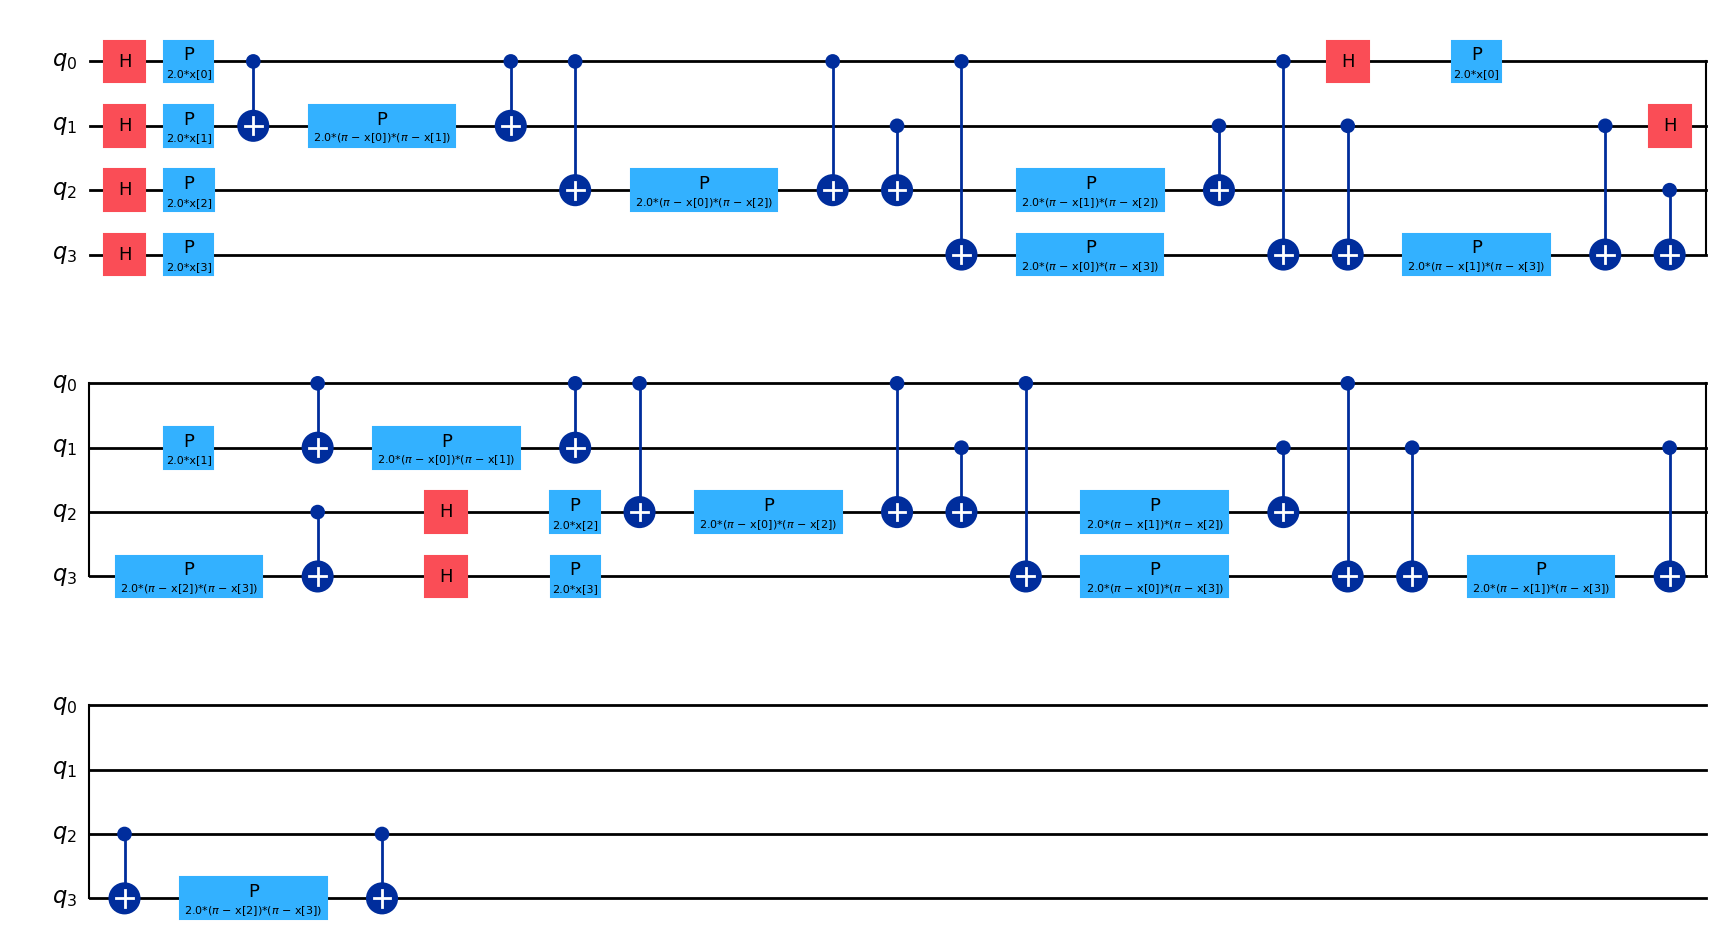

In [3]:
#Select feature map
ft_map=ZZFeatureMap(4, reps=2,entanglement='full')
ft_map.decompose(reps=1).draw('mpl',style="iqp")

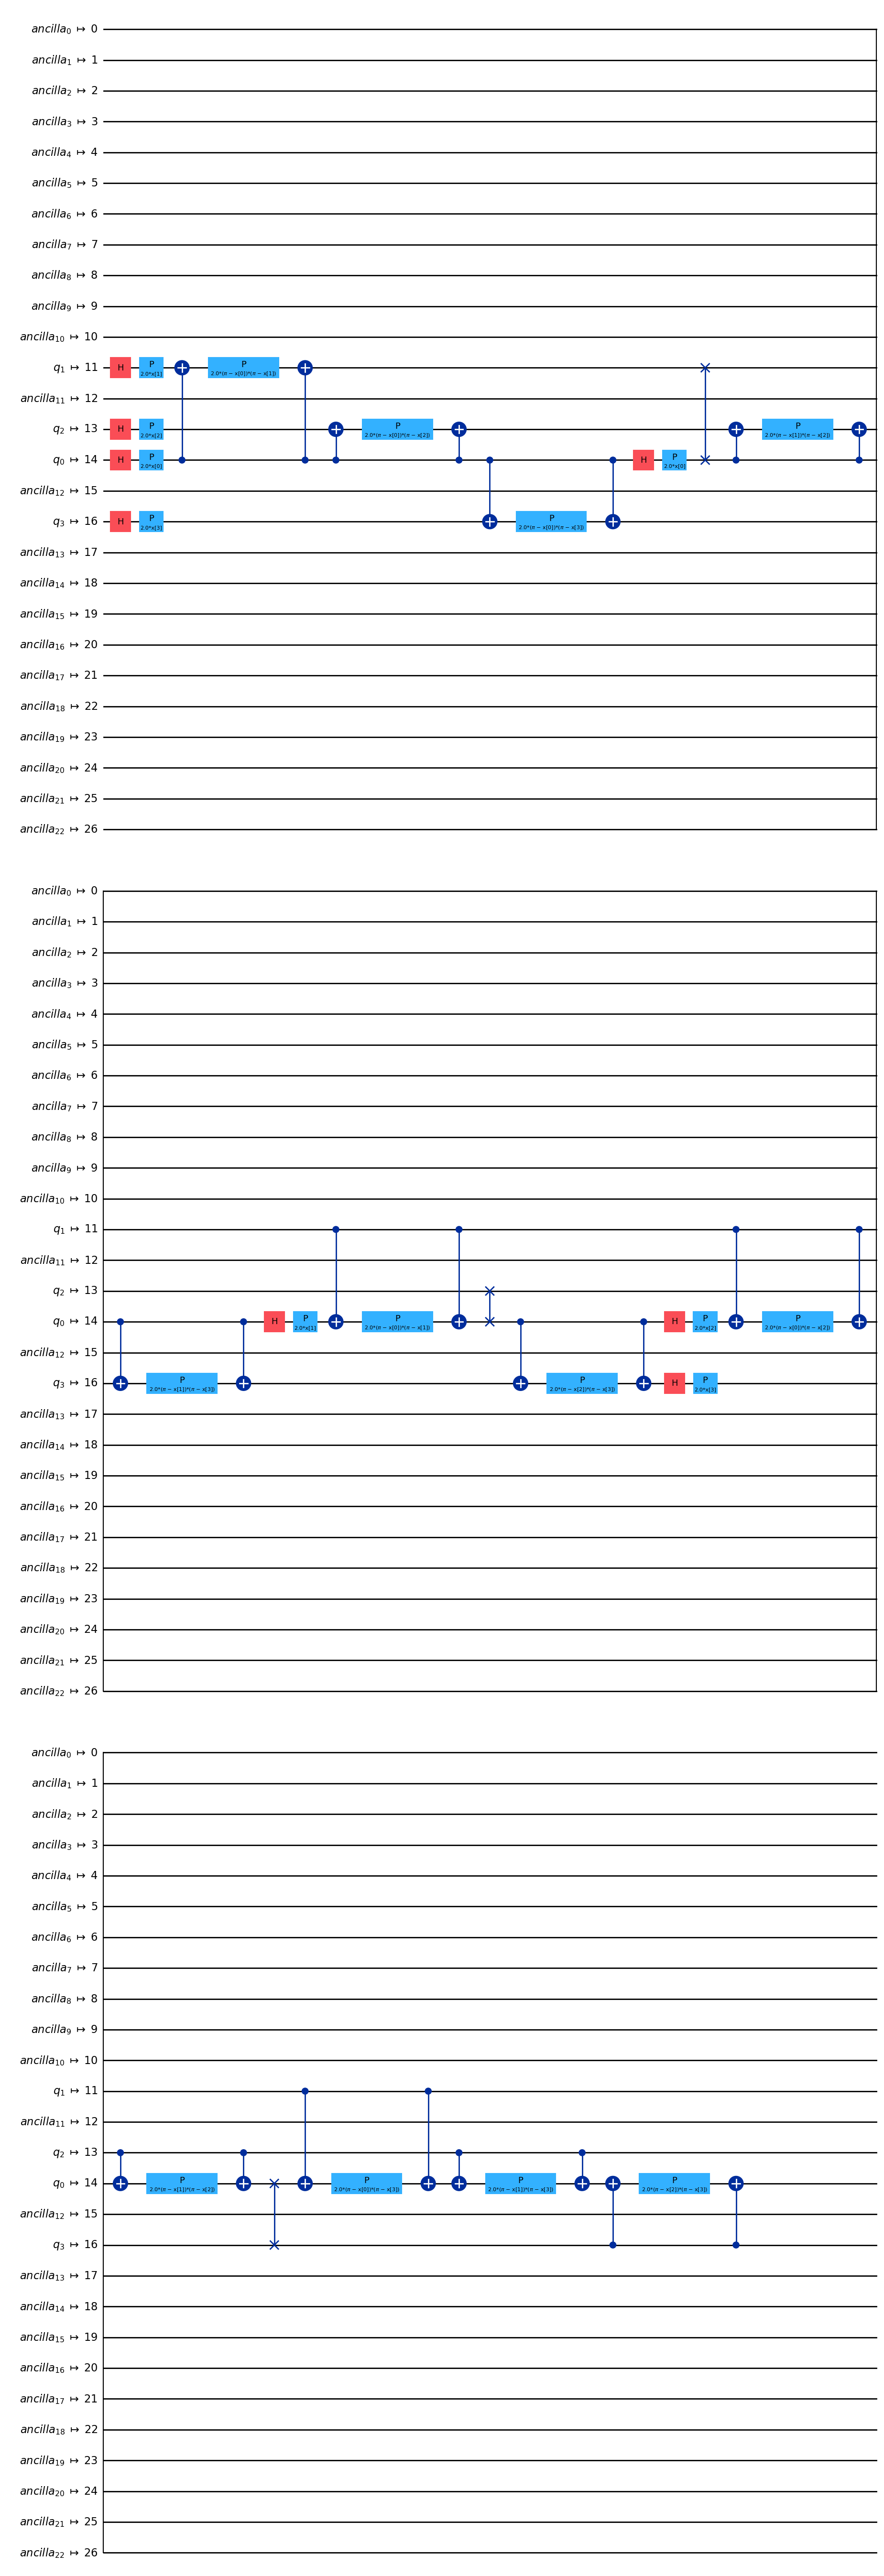

In [4]:
#Get transpiled ftmap
ft_map_t_qs = transpile(ft_map,coupling_map=coupling_map,optimization_level=3,seed_transpiler=402)
ft_map_t_qs.draw('mpl',style="iqp")



In [5]:
#Set options
#Set primitive sampler options
options = Options()
#Error mitigation level (resilience_level)
options.resilience_level = 1
#Optimization level
options.optimization_level = 1
#Number of shots
options.execution.shots = 1024
#Skip translation since the circuit is already transpiled
options.skip_translation = True

# Create a quantum kernel based on the transpiled feature map
#Set Primitive sampler
sampler = qiskit_ibm_runtime.Sampler(backend=backend,options=options)
#Set fidelity
fidelity = ComputeUncompute(sampler=sampler)
#Set kernel
qkernel = FidelityQuantumKernel(feature_map=ft_map_t_qs,fidelity=fidelity)

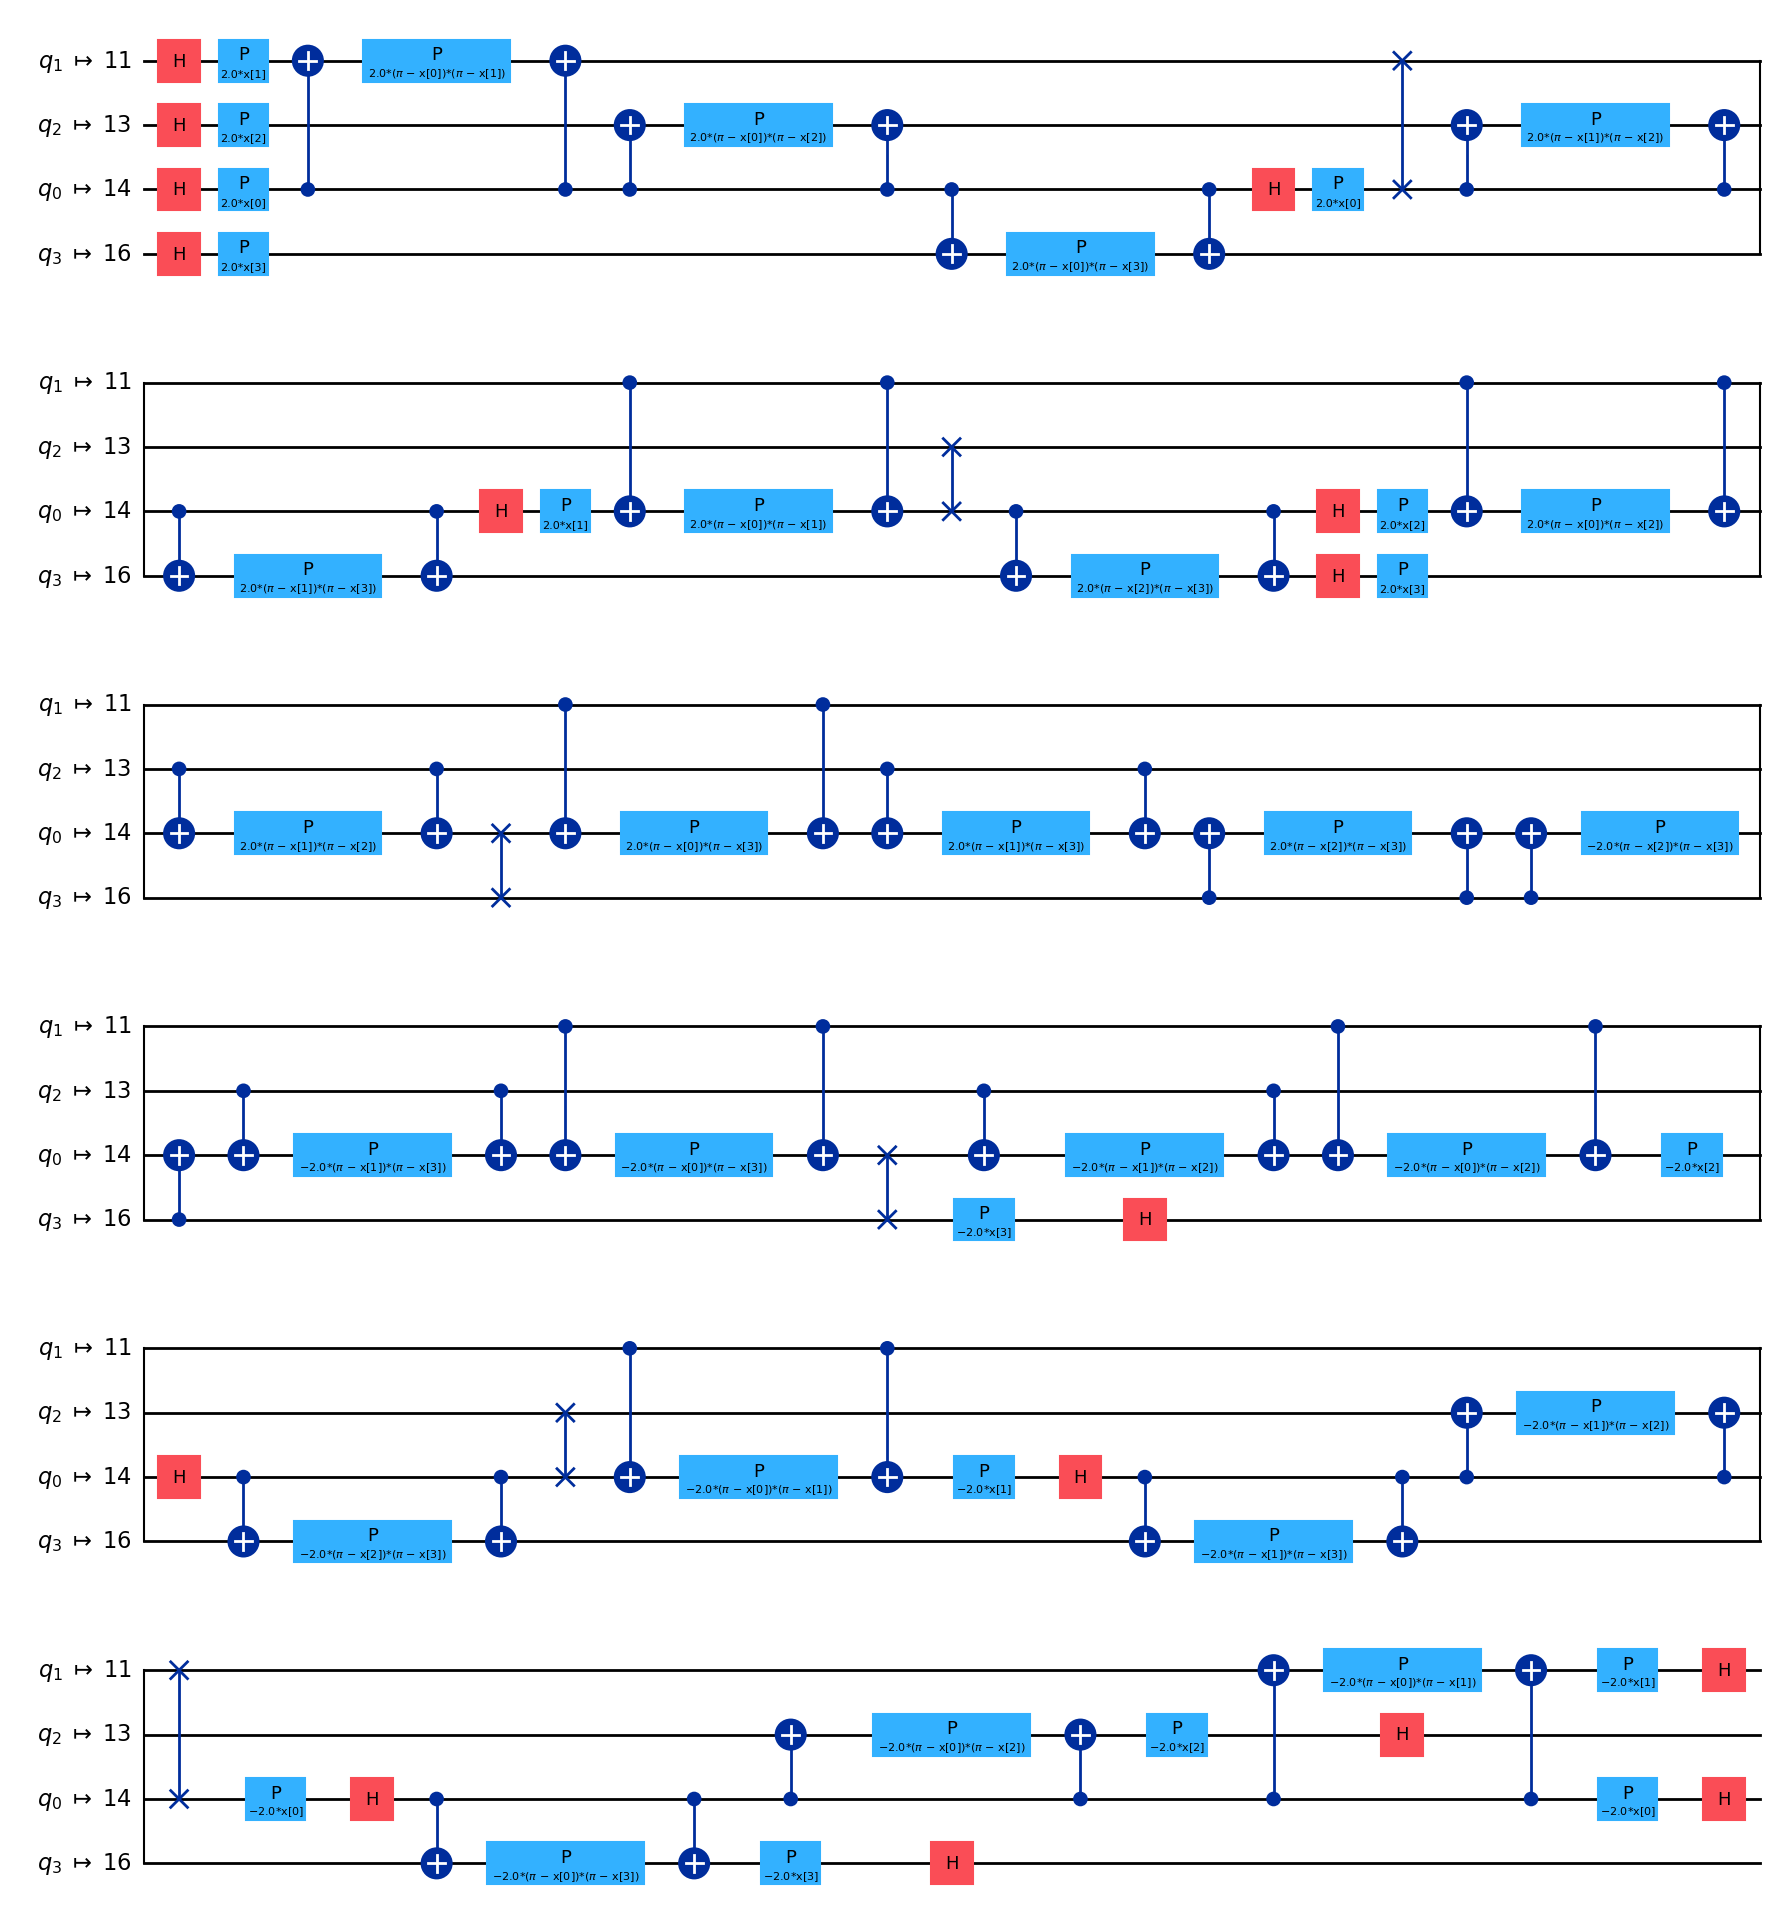

In [6]:
#Get kernel final circuit
circuit_tot=fidelity.create_fidelity_circuit(ft_map_t_qs,ft_map_t_qs)
circuit_tot.remove_final_measurements()
circuit_tot.draw('mpl',style='iqp', idle_wires=False,cregbundle=False)

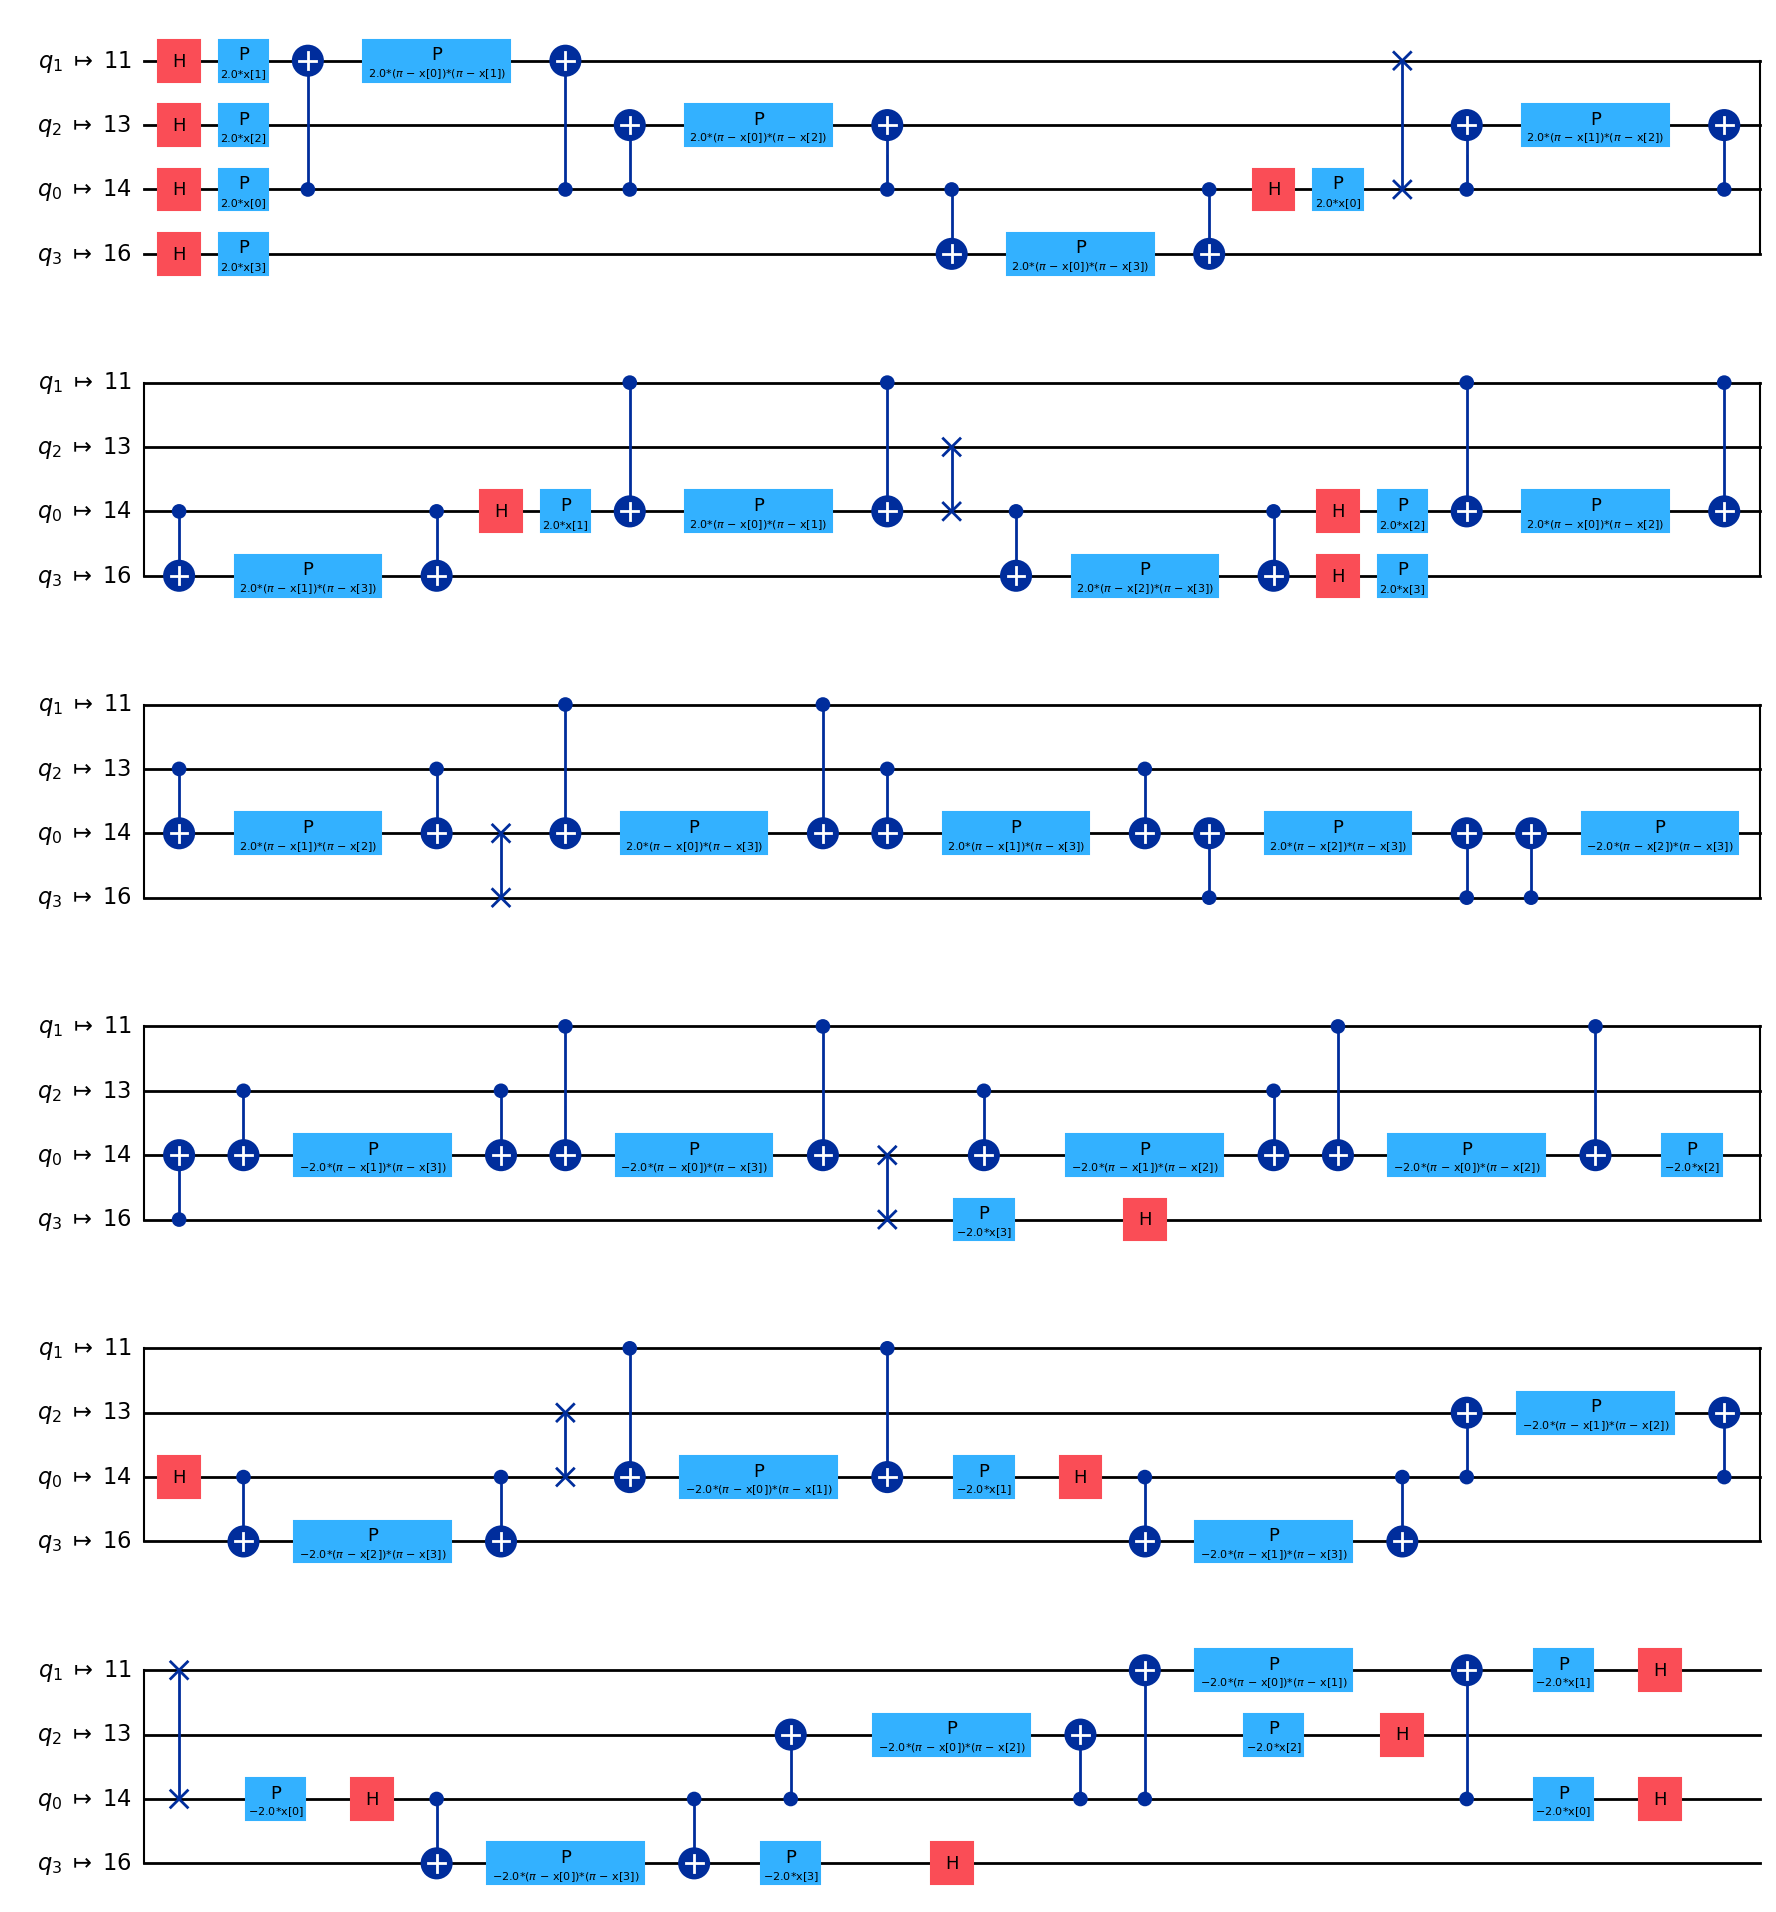

In [7]:
#Now we compose the kernel with the circuit
circuit_tot_2=ft_map_t_qs.compose(ft_map_t_qs.inverse())
circuit_tot_2.draw('mpl',style='iqp', idle_wires=False,cregbundle=False)

In [8]:
#Compare the two circuits
print('circuit 1 depth:',circuit_tot.depth())
print('Gate counts circuit 1:', circuit_tot.count_ops())
print('circuit 2 depth:',circuit_tot_2.depth())
print('Gate counts circuit 2:', circuit_tot_2.count_ops())


circuit 1 depth: 94
Gate counts circuit 1: OrderedDict({'cx': 48, 'p': 40, 'h': 16, 'swap': 6})
circuit 2 depth: 94
Gate counts circuit 2: OrderedDict({'cx': 48, 'p': 40, 'h': 16, 'swap': 6})


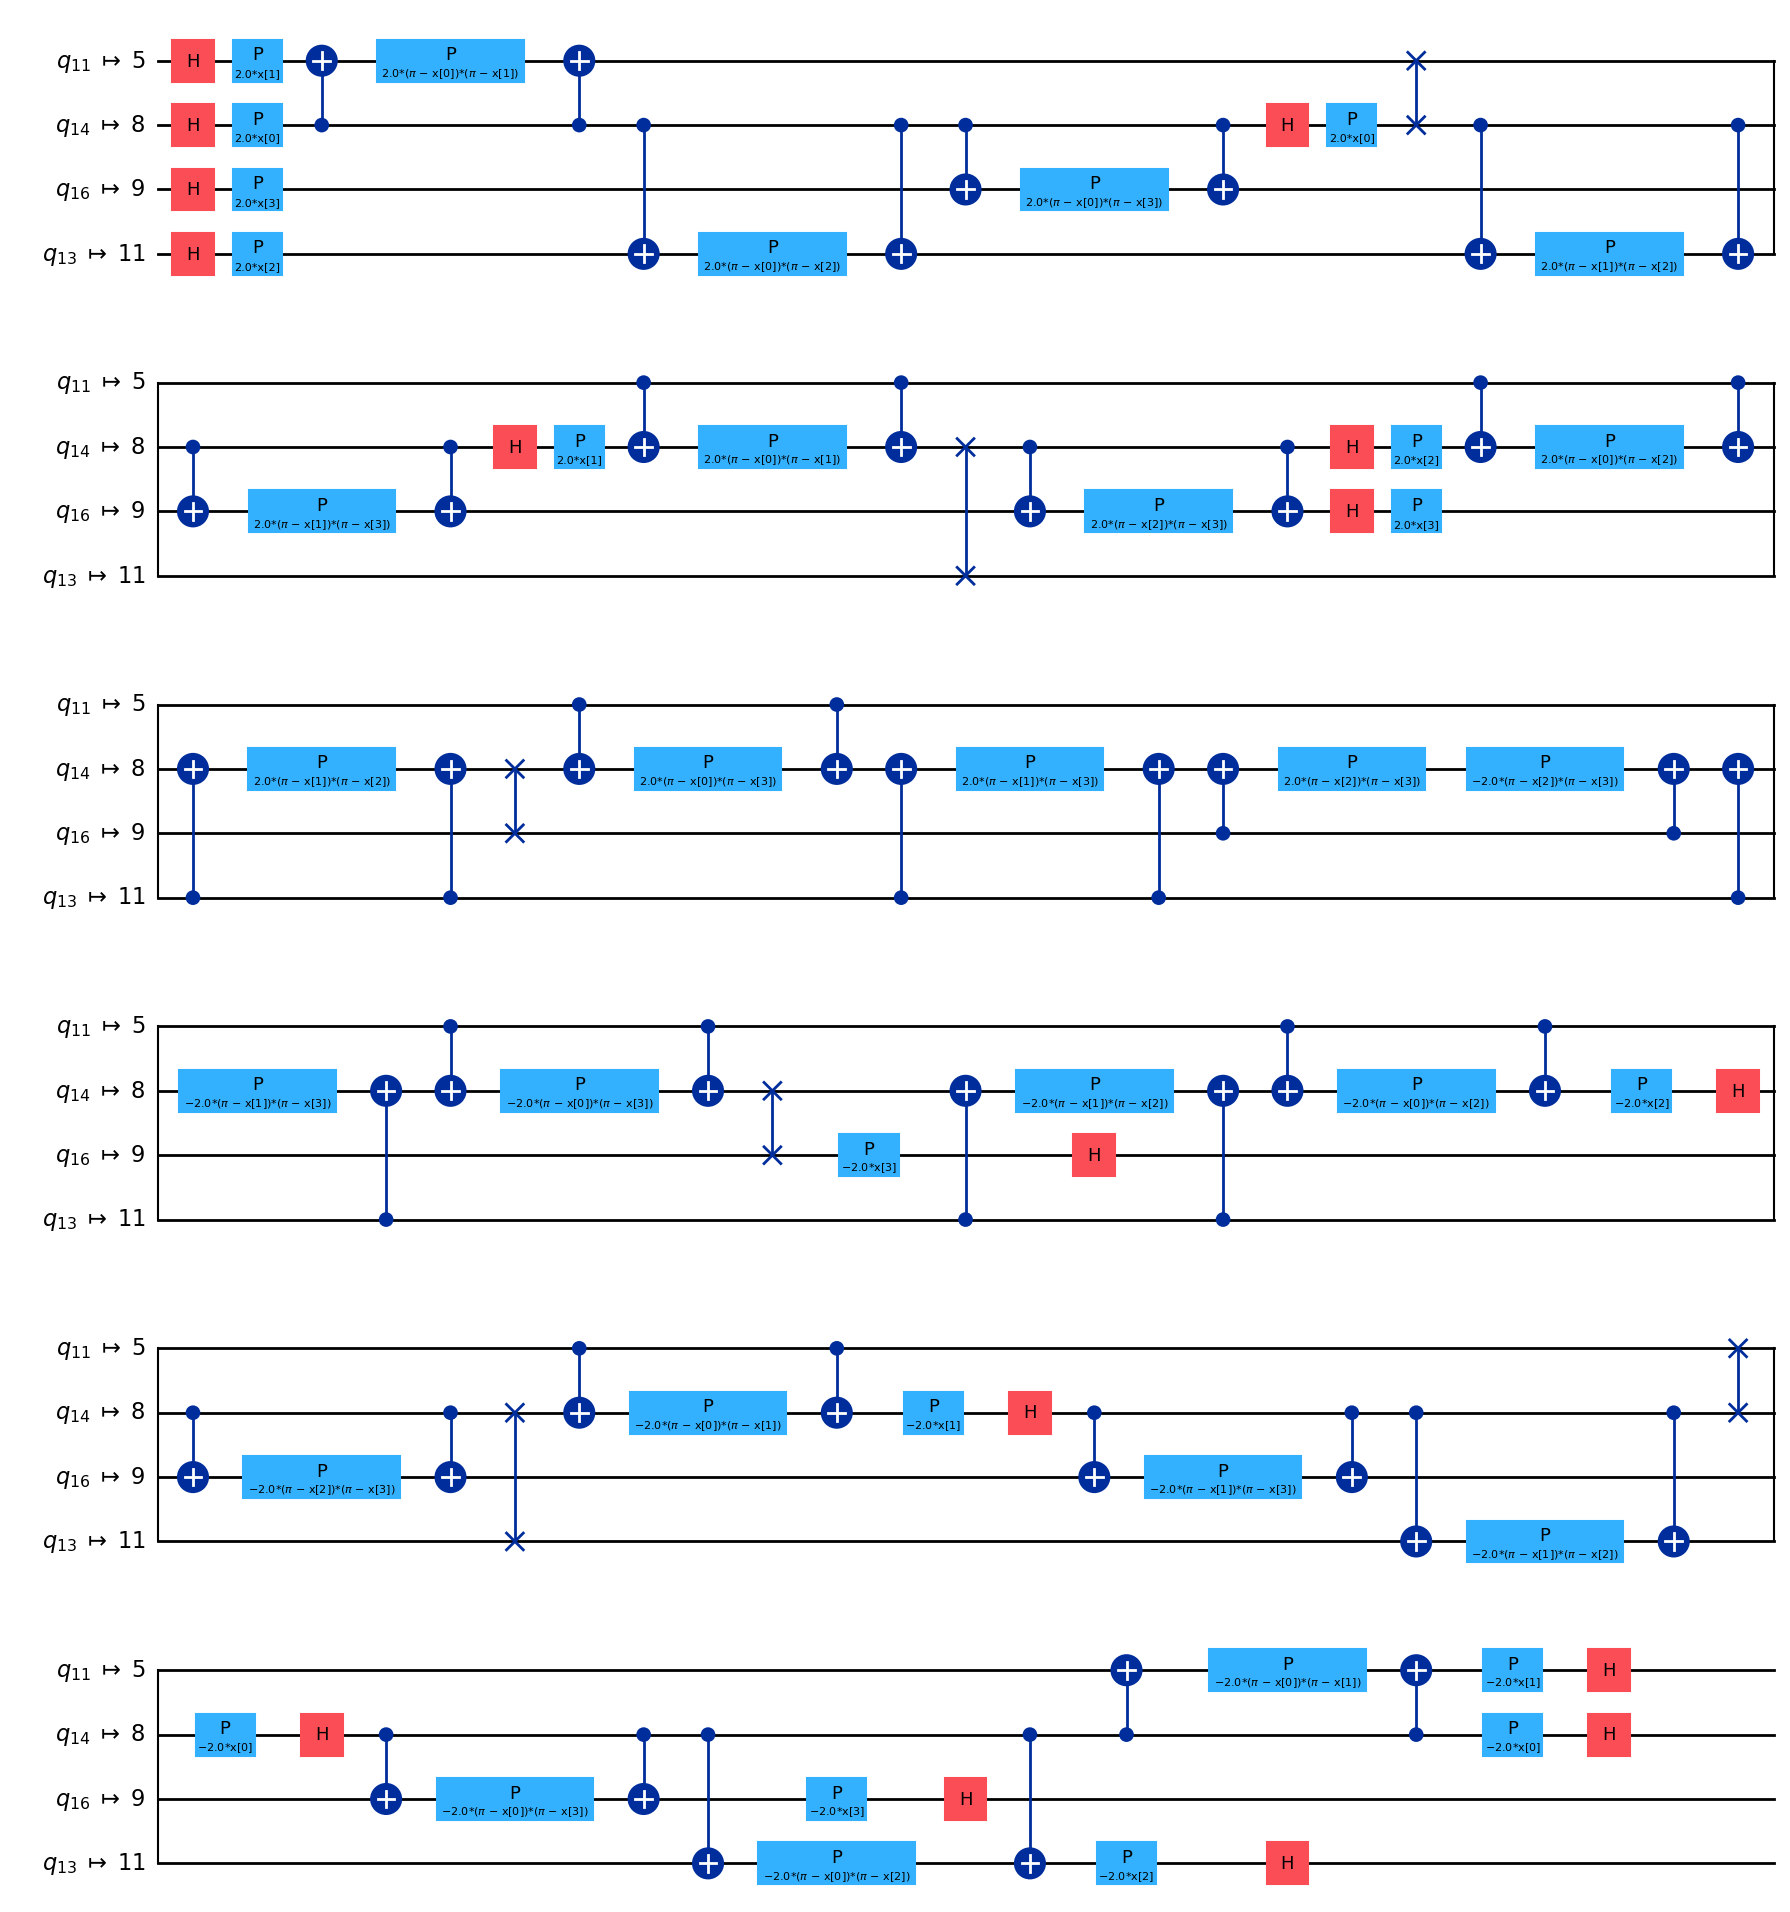

In [9]:
#Optimize the circuit(transpile the full circuit)
circuit_tot_2_opt=transpile(circuit_tot_2,coupling_map=coupling_map,optimization_level=3,seed_transpiler=402)
circuit_tot_2_opt.draw('mpl',style='iqp', idle_wires=False,cregbundle=False)

In [10]:
print('circuit fully transpiled depth:',circuit_tot_2_opt.depth())
print('Gate counts circuit fully transpiled:', circuit_tot_2_opt.count_ops())


circuit fully transpiled depth: 92
Gate counts circuit fully transpiled: OrderedDict({'cx': 46, 'p': 40, 'h': 16, 'swap': 6})


In [11]:
#Test on directly transpiled full kernel
circuit_tot_3=ft_map.compose(ft_map.inverse())
circuit_tot_3_opt=transpile(circuit_tot_3,coupling_map=coupling_map,optimization_level=3,seed_transpiler=402)
circuit_tot_3_opt.draw('mpl',style='iqp', idle_wires=False,cregbundle=False)
print('circuit fully transpiled depth:',circuit_tot_3_opt.depth())
print('Gate counts circuit fully transpiled:', circuit_tot_3_opt.count_ops())


circuit fully transpiled depth: 92
Gate counts circuit fully transpiled: OrderedDict({'cx': 46, 'p': 40, 'h': 16, 'swap': 8})
